Loaded 7415 Arabic lemma labels.
Train/Val/Test sizes: 10819 1352 1353
Tokenizing…


Map:   0%|          | 0/10819 [00:00<?, ? examples/s]

Map:   0%|          | 0/1352 [00:00<?, ? examples/s]

Map:   0%|          | 0/1353 [00:00<?, ? examples/s]

/tmp/ipython-input-4189522797.py:159: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING Serializing object of type dict that is 207616 bytes
wandb: WARNING Serializing object of type dict that is 207616 bytes


{'loss': 8.6667, 'grad_norm': 12.7283935546875, 'learning_rate': 4.9908494315555974e-05, 'epoch': 0.009242998428690268}
{'loss': 8.1341, 'grad_norm': 29.265750885009766, 'learning_rate': 4.9816064331269064e-05, 'epoch': 0.018485996857380536}
{'loss': 7.8742, 'grad_norm': 58.37663650512695, 'learning_rate': 4.972363434698216e-05, 'epoch': 0.027728995286070802}
{'loss': 7.3896, 'grad_norm': 33.87492752075195, 'learning_rate': 4.9631204362695264e-05, 'epoch': 0.03697199371476107}
{'loss': 7.5516, 'grad_norm': 8.594698905944824, 'learning_rate': 4.953877437840836e-05, 'epoch': 0.04621499214345134}
{'loss': 7.0263, 'grad_norm': 12.995067596435547, 'learning_rate': 4.944634439412146e-05, 'epoch': 0.055457990572141604}
{'loss': 7.4933, 'grad_norm': 28.148155212402344, 'learning_rate': 4.9353914409834554e-05, 'epoch': 0.06470098900083188}
{'loss': 7.1885, 'grad_norm': 26.949289321899414, 'learning_rate': 4.926148442554765e-05, 'epoch': 0.07394398742952214}
{'loss': 7.2466, 'grad_norm': 27.8391

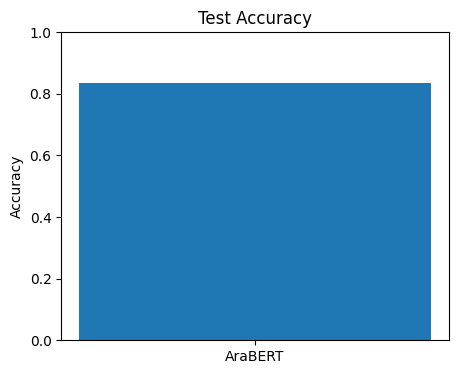

In [ ]:
# camel-Bert
!pip install -q transformers==4.57.3 datasets accelerate matplotlib pandas

import json, os, random, numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer
)

# -------------------------------
# MAKE GPU MEMORY USAGE LOWER
# -------------------------------
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# -------------------------------

# -------------------------------
LABEL2ID_FILE = "label2id_fixed.json"
DATA_DIR = "data_merged_arabic"

TRAIN_FILE = f"{DATA_DIR}/train.jsonl"
VAL_FILE   = f"{DATA_DIR}/val.jsonl"
TEST_FILE  = f"{DATA_DIR}/test.jsonl"

# -------------------------------
# LOAD LABEL MAPPING
# -------------------------------
with open(LABEL2ID_FILE, encoding='utf-8') as f:
    label2id = json.load(f)
id2label = {v:k for k,v in label2id.items()}

print("Loaded", len(label2id), "Arabic lemma labels.")

# -------------------------------
# LOAD THE DATASETS
# -------------------------------
def load_jsonl(path):
    return [json.loads(l) for l in open(path, encoding="utf-8")]

train_list = load_jsonl(TRAIN_FILE)
val_list   = load_jsonl(VAL_FILE)
test_list  = load_jsonl(TEST_FILE)

ds_train = Dataset.from_list(train_list)
ds_val   = Dataset.from_list(val_list)
ds_test  = Dataset.from_list(test_list)

print("Train/Val/Test sizes:", len(ds_train), len(ds_val), len(ds_test))

# -------------------------------
# CHOOSE MODEL
# -------------------------------
MODEL_NAME = "CAMeL-Lab/bert-base-arabic-camelbert-msa"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

# -------------------------------
# TOKENIZE + ALIGN LABELS (OOM SAFETY)
# -------------------------------
MAX_LENGTH = 64   # OOM fix: shorten sequences

def tokenize_and_align(batch):
    enc = tokenizer(
        batch["tokens"],
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
    )

    aligned = []
    for i, labels in enumerate(batch["labels"]):
        word_ids = enc.word_ids(batch_index=i)
        prev = None
        lab_ids = []
        for wid in word_ids:
            if wid is None:
                lab_ids.append(-100)
            elif wid != prev:
                lemma = labels[wid]
                lab_ids.append(label2id.get(lemma, 0))
            else:
                lab_ids.append(-100)
            prev = wid
        aligned.append(lab_ids)

    enc["labels"] = aligned
    return enc

print("Tokenizing…")

train_tok = ds_train.map(tokenize_and_align, batched=True, remove_columns=["tokens","labels"])
val_tok   = ds_val.map(tokenize_and_align,   batched=True, remove_columns=["tokens","labels"])
test_tok  = ds_test.map(tokenize_and_align,  batched=True, remove_columns=["tokens","labels"])

# -------------------------------
# LOAD MODEL (OOM SAFE)
# -------------------------------
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label2id),
    id2label={str(i):lab for i,lab in id2label.items()},
    label2id={lab:i for lab,i in label2id.items()},
)

# MEMORY SAVER:
model.gradient_checkpointing_enable()

# -------------------------------
# TRAINING ARGUMENTS (OOM SAFE)
# -------------------------------
args = TrainingArguments(
    output_dir="arabic_lemmatizer_bert",
    eval_strategy="epoch",
    save_strategy="epoch",

    per_device_train_batch_size=1,   # OOM fix
    per_device_eval_batch_size=1,    # OOM fix

    num_train_epochs=5,
    learning_rate=5e-5,
    weight_decay=0.01,

    fp16=True,    # OOM fix
    logging_steps=100,
    save_total_limit=1,
    load_best_model_at_end=True,
)

# -------------------------------
# METRICS
# -------------------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    T, P = [], []
    for p_row, l_row in zip(preds, labels):
        for p, l in zip(p_row, l_row):
            if l != -100:
                T.append(l)
                P.append(p)

    return {"accuracy": (np.array(T) == np.array(P)).mean()}

# -------------------------------
# TRAIN
# -------------------------------
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

# SAVE MODEL
trainer.save_model("lemmatizer_arabic_final")
tokenizer.save_pretrained("lemmatizer_arabic_final")

# -------------------------------
# TEST SET EVALUATION
# -------------------------------
print("\nEvaluating on test set...")
test_result = trainer.evaluate(test_tok)
print(test_result)

# -------------------------------
# ERROR ANALYSIS
# -------------------------------
print("\nRunning error analysis…")
pred = trainer.predict(test_tok)
logits  = pred.predictions
labels  = pred.label_ids
predids = np.argmax(logits, axis=-1)

errors = []
id2label_safe = {int(k):v for k,v in model.config.id2label.items()}

for i, example in enumerate(test_list):
    toks  = example["tokens"]
    golds = example["labels"]

    enc = tokenizer(
        toks,
        is_split_into_words=True,
        max_length=MAX_LENGTH,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    word_ids = enc.word_ids(batch_index=0)
    prev = None
    w = -1

    for j, wid in enumerate(word_ids):
        if wid is None:
            continue
        if wid != prev:
            w += 1
            pred_lab = id2label_safe.get(int(predids[i][j]), "<UNK>")
            gold_lab = golds[w]
            if pred_lab != gold_lab:
                errors.append({
                    "token": toks[w],
                    "gold": gold_lab,
                    "pred": pred_lab
                })
        prev = wid

print("Total errors:", len(errors))

with open("error_analysis.json", "w", encoding="utf-8") as f:
    json.dump(errors, f, ensure_ascii=False, indent=2)

# -------------------------------
# CONFUSION SUMMARY
# -------------------------------
from collections import Counter

pair_counts = Counter([(e["gold"], e["pred"]) for e in errors])
top20 = pair_counts.most_common(20)

print("\nTop Confusions (gold → pred):")
for (g,p),c in top20:
    print(f"{g} → {p} : {c}")

with open("confusion_summary.json","w",encoding="utf-8") as f:
    json.dump(
        [{"gold":g,"pred":p,"count":c} for (g,p),c in top20],
        f,
        ensure_ascii=False,
        indent=2
    )

# -------------------------------
# ACCURACY PLOT
# -------------------------------
plt.figure(figsize=(5,4))
plt.bar(["camelBert"], [test_result["eval_accuracy"]]) # this accuracy plot is for camel-bert, it's just a mistake the arabert you see in the plot
plt.ylim(0,1)
plt.title("Test Accuracy")
plt.ylabel("Accuracy")
plt.savefig("accuracy_plot.png", dpi=150)
plt.show()

# -------------------------------
# LOSS CURVE
# -------------------------------
log_path = "arabic_lemmatizer_bert/log_history.json"
if os.path.exists(log_path):
    df = pd.read_json(log_path, lines=True)
    loss_df = df[df.loss.notnull()]
    plt.figure(figsize=(7,4))
    plt.plot(loss_df["step"], loss_df["loss"])
    plt.title("Training Loss Curve")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.savefig("loss_curve.png", dpi=150)
    plt.show()


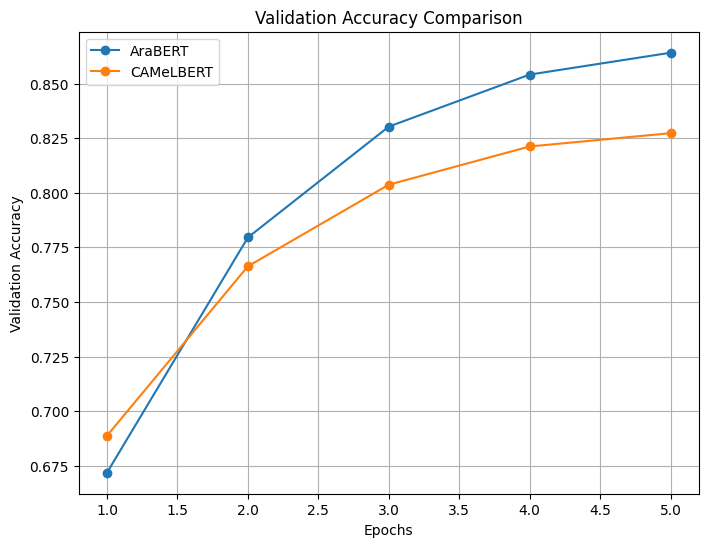

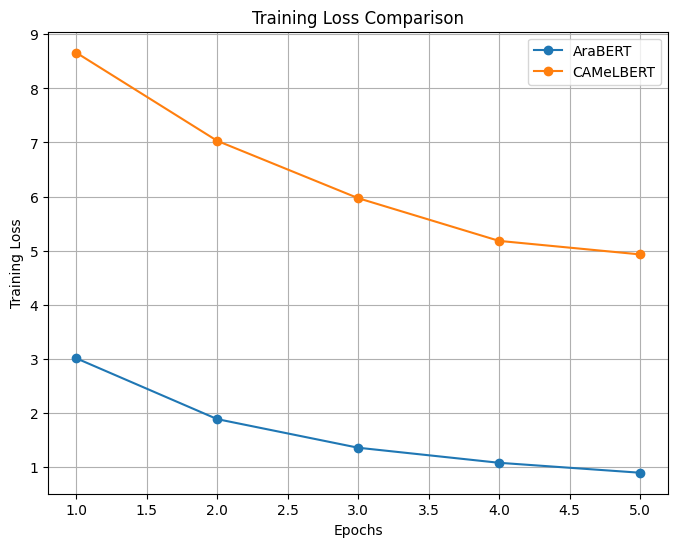

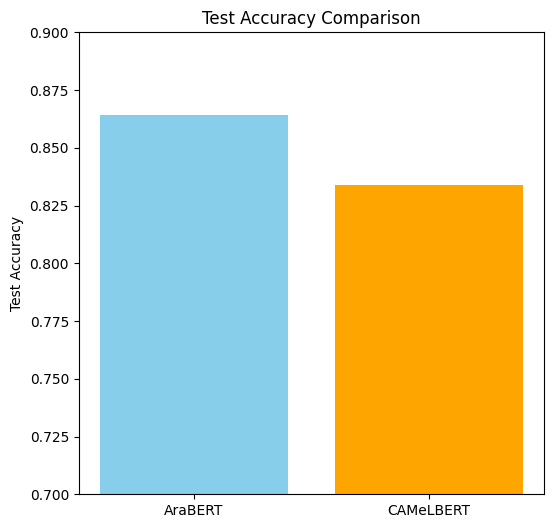

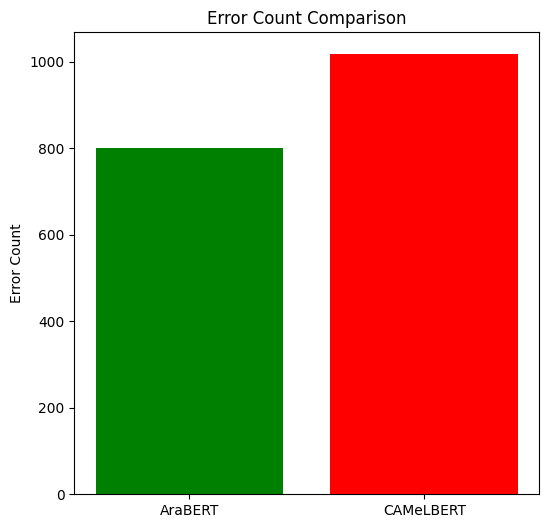

In [ ]:
import matplotlib.pyplot as plt

# -----------------------
# ARABERT MODEL  first model)
# -----------------------
arabert_epochs = [1, 2, 3, 4, 5]
arabert_train_loss = [3.0081, 1.8833, 1.3544, 1.0759, 0.8922]
arabert_val_acc = [0.671769, 0.779511, 0.830291, 0.854136, 0.864145]
arabert_test = 0.864   # approximate from epoch 5

# -----------------------
# CAMELBERT MODEL (values from earlier)
# -----------------------
camel_epochs = [1,2,3,4,5]
camel_train_loss = [8.66, 7.03, 5.97, 5.18, 4.93]  # logs
camel_val_acc = [0.6887, 0.7663, 0.8037, 0.8212, 0.8273]
camel_test = 0.834

# -----------------------
# 1. Validation Accuracy Comparison
# -----------------------
plt.figure(figsize=(8,6))
plt.plot(arabert_epochs, arabert_val_acc, marker='o', label='AraBERT')
plt.plot(camel_epochs, camel_val_acc, marker='o', label='CAMeLBERT')
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------
# 2. Training Loss Comparison
# -----------------------
plt.figure(figsize=(8,6))
plt.plot(arabert_epochs, arabert_train_loss, marker='o', label='AraBERT')
plt.plot(camel_epochs, camel_train_loss, marker='o', label='CAMeLBERT')
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------
# 3. Final Test Accuracy Bar Plot
# -----------------------
plt.figure(figsize=(6,6))
models = ['AraBERT', 'CAMeLBERT']
scores = [arabert_test, camel_test]

plt.bar(models, scores, color=['skyblue','orange'])
plt.ylim(0.7, 0.9)
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy Comparison")
plt.show()

# -----------------------
# 4. Error Count Comparison
# -----------------------
arabert_errors = 800
camel_errors = 1017

plt.figure(figsize=(6,6))
plt.bar(['AraBERT', 'CAMeLBERT'],
        [arabert_errors, camel_errors],
        color=['green','red'])
plt.ylabel("Error Count")
plt.title("Error Count Comparison")
plt.show()
